<a href="https://colab.research.google.com/github/egynk3/simpleNeuralNetwork/blob/main/notebooks/SimpleNN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Epoch 1/100, Train Loss: 0.1966, Val Loss: 0.0644
Epoch 2/100, Train Loss: 0.0451, Val Loss: 0.0232
Epoch 3/100, Train Loss: 0.0159, Val Loss: 0.0081
Epoch 4/100, Train Loss: 0.0064, Val Loss: 0.0043
Epoch 5/100, Train Loss: 0.0032, Val Loss: 0.0021
Epoch 6/100, Train Loss: 0.0019, Val Loss: 0.0014
Epoch 7/100, Train Loss: 0.0014, Val Loss: 0.0011
Epoch 8/100, Train Loss: 0.0010, Val Loss: 0.0008
Epoch 9/100, Train Loss: 0.0008, Val Loss: 0.0008
Epoch 10/100, Train Loss: 0.0007, Val Loss: 0.0006
Epoch 11/100, Train Loss: 0.0006, Val Loss: 0.0005
Epoch 12/100, Train Loss: 0.0005, Val Loss: 0.0005
Epoch 13/100, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 14/100, Train Loss: 0.0004, Val Loss: 0.0004
Epoch 15/100, Train Loss: 0.0004, Val Loss: 0.0003
Epoch 16/100, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 17/100, Train Loss: 0.0003, Val Loss: 0.0003
Epoch 18/100, Train Loss: 0.0003, Val Loss: 0.0004
Epoch 19/100, Train Loss: 0.0002, Val Loss: 0.0002
Epoch 20/100, Train Loss: 0.0002, Val Lo

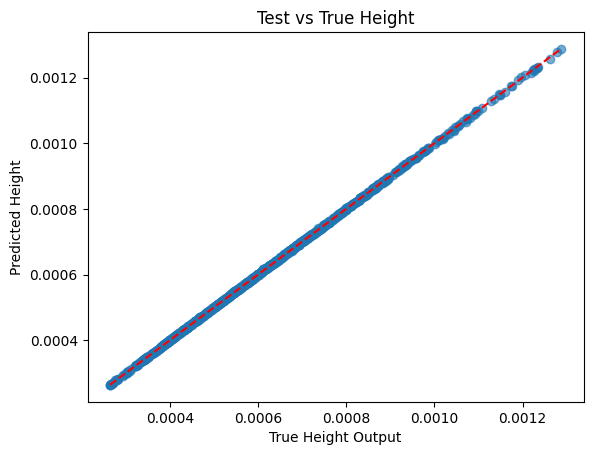

In [2]:
#importing relevant libs
import numpy as np               # Numerical operations
import pandas as pd              # Data handling (e.g., read CSV files)
from sklearn.model_selection import train_test_split   # Split data into train/test
from sklearn.preprocessing import StandardScaler       # Normalize features
#pytorch
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import Dataset, DataLoader, TensorDataset
#evaluation and vizualization
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score

#importing data
url='https://github.com/egynk3/simpleNeuralNetwork/raw/main/Data/AllData.xlsx'
df = pd.read_excel(url)

#normalize data:
#df mean=mean of each column in dataframe
#df-df.mean= subtract column mean from each value in column
#data now centered around zero
#df.std std of ech column as a series
#after, mean=zero and standard deviation of each col=1
#not normalizing outputs, axis=1 =cols
#splitting into features and targets

features = df.drop('h', axis=1)
target = df['h']
features_norm = (features - features.mean()) / features.std()
X=features_norm.values
y=target.values
#######################################################################
#splitting dataset into training set and temporary set(for val and test):
#.3=30% data goes into temp, 70% to train
X_train, X_temp, y_train, y_temp = train_test_split(X, y, test_size=0.3, random_state=33)
#splitting temporary into val and test set, 50/50 split
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, random_state=33)

########################################################
#scale inputs and outputs
#creation of scalar objects
scaler_X = StandardScaler()
scaler_y = StandardScaler()
#mean and std of each column, transform applies to all values
X_train_scaled = scaler_X.fit_transform(X_train)
#fit not called to avoid data leakage, scaled using training data mean and std
X_val_scaled = scaler_X.transform(X_val)
X_test_scaled = scaler_X.transform(X_test)
#reshaping to a 2d array
y_train_scaled = scaler_y.fit_transform(y_train.reshape(-1, 1))
y_val_scaled = scaler_y.transform(y_val.reshape(-1, 1))
y_test_scaled = scaler_y.transform(y_test.reshape(-1, 1))

#currently all numpy arrays
########################################################


########################################################
##define network architecture
class outputHeight(nn.Module):
    def __init__(self, input_size):
        super(outputHeight, self).__init__()
        #layer definiton
        self.model = nn.Sequential(
            nn.Linear(input_size, 64),#input to hidden layer
            nn.ReLU(), #activation
            nn.Linear(64,32), #hidden to hidden
            nn.ReLU(),
            nn.Linear(32,1) #hidden to output
        )
    def forward(self, x):
        return self.model(x)
#OPTIONAL         drop out + batch normalization for training stability

#instantiate model
input_dim = X_train_scaled.shape[1]
model = outputHeight(input_dim)

#define loss funciton
lossFunc = nn.MSELoss() #regression
#define optimizer
optimizer = optim.Adam(model.parameters(), lr=0.001)
#optional                             metric tracker r^2
#convertin numpy arrays to pytorch tensors
x_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train_scaled, dtype=torch.float32)
x_val_tensor = torch.tensor(X_val_scaled, dtype=torch.float32)
y_val_tensor = torch.tensor(y_val_scaled, dtype=torch.float32)
#dataloader objects for batching
train_dataset = TensorDataset(x_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_dataset = TensorDataset(x_val_tensor, y_val_tensor)
val_loader = DataLoader(val_dataset, batch_size=32, shuffle=False)
num_epochs = 100
#feed training data into model
for epoch in range(num_epochs):
    model.train()#model in training mode
    train_loss= 0.0
    for batch_x, batch_y in train_loader:
        optimizer.zero_grad() #clear prev gradients
        outputs = model(batch_x) #forward pass
        loss = lossFunc(outputs, batch_y) #compute loss
        loss.backward() #packpropagation
        optimizer.step() #updating weights
        train_loss += loss.item()*batch_x.size(0) #accumulating loss
    train_loss /= len(train_loader.dataset) #average loss over epoch

    #validation loop, monitering overfitting
    model.eval()
    val_loss = 0.0
    with torch.no_grad(): #no gradients during validation
        val_outputs = model(x_val_tensor)
        val_loss = lossFunc(val_outputs, y_val_tensor).item()
    print(f"Epoch {epoch+1}/{num_epochs}, Train Loss: {train_loss:.4f}, Val Loss: {val_loss:.4f}")

    if epoch == 0:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth')
    elif val_loss < best_val_loss:
        best_val_loss = val_loss
        torch.save(model.state_dict(), 'best_model.pth') #save best model

#load best model
model.load_state_dict(torch.load('best_model.pth'))
model.eval()

#convert test numpy arrays to tensors
x_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test_scaled, dtype=torch.float32)

#run predictions on test set
with torch.no_grad():
    y_pred_test_scaled = model(x_test_tensor)
    #INVERSE SCALING
    y_pred_test = scaler_y.inverse_transform(y_pred_test_scaled.numpy())
    y_true_test = scaler_y.inverse_transform(y_test_scaled)
    #evaluate performance
    mse = mean_squared_error(y_true_test, y_pred_test)
    mae = mean_absolute_error(y_true_test, y_pred_test)
    r2 = r2_score(y_true_test, y_pred_test)
    print(f"MSE: {mse:.4f}, MAE: {mae:.4f}, R^2: {r2:.4f}")
    #visualisation
    plt.scatter(y_true_test, y_pred_test, alpha=0.6)
    plt.xlabel('True Height Output')
    plt.ylabel('Predicted Height')
    plt.title('Test vs True Height')
    plt.plot([y_true_test.min(), y_true_test.max()],
             [y_true_test.min(), y_true_test.max()],
             'r--')
    plt.show()



